In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [ ]:
%cp '/gdrive/My Drive/damaged_buildings.zip' .
!unzip damaged_buildings.zip

Streaming output truncated to the last 5000 lines.
  inflating: train_another/no_damage/-95.627453_29.859303000000004.jpeg  
  inflating: train_another/no_damage/-95.62745600000001_29.777524.jpeg  
  inflating: train_another/no_damage/-95.627485_29.777865999999996.jpeg  
  inflating: train_another/no_damage/-95.62751800000001_29.857785999999997.jpeg  
  inflating: train_another/no_damage/-95.62751999999999_29.860796999999998.jpeg  
  inflating: train_another/no_damage/-95.627523_29.770004999999998.jpeg  
  inflating: train_another/no_damage/-95.62753000000001_29.863289.jpeg  
  inflating: train_another/no_damage/-95.627539_29.827047999999998.jpeg  
  inflating: train_another/no_damage/-95.627543_29.860021000000003.jpeg  
  inflating: train_another/no_damage/-95.627563_29.8628.jpeg  
  inflating: train_another/no_damage/-95.627579_29.864051.jpeg  
  inflating: train_another/no_damage/-95.627595_29.776602.jpeg  
  inflating: train_another/no_damage/-95.62759799999999_29.777317.jpeg  
  i

In [ ]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0" #model will be trained on GPU 0
import keras
from matplotlib import pyplot as plt
import numpy as np
import gzip
%matplotlib inline
from keras.models import Model
from keras.optimizers import RMSprop
from keras.layers import Input,Dense,Flatten,Dropout,merge,Reshape,Conv2D,MaxPooling2D,UpSampling2D,Conv2DTranspose
from keras.layers.normalization import BatchNormalization
from keras.models import Model,Sequential
from keras.callbacks import ModelCheckpoint
from keras.optimizers import Adadelta, RMSprop,SGD,Adam
from keras import regularizers
from keras import backend as K
from keras.utils import to_categorical
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D,GlobalAveragePooling2D

from sklearn.metrics import classification_report

from keras import backend as K

from keras.callbacks import ModelCheckpoint

In [ ]:

#DIRECTORY = r"/gdrive/My Drive/filtrado/160/"
CATEGORIES = ["damage", "no_damage"]

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")

# perform one-hot encoding on the labels
lb = LabelBinarizer()

trainX = []
trainY = []
for category in CATEGORIES:
    path = os.path.join('train_another/', category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(128, 128, 3))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	trainX.append(image)
    	trainY.append(category)
     
trainX = np.array(trainX, dtype="float32")
trainY = lb.fit_transform(trainY)
trainY = to_categorical(trainY)
trainY = np.array(trainY)

valX = []
valY = []
for category in CATEGORIES:
    path = os.path.join('validation_another/', category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(128, 128, 3))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	valX.append(image)
    	valY.append(category)
     
valX = np.array(valX, dtype="float32")
valY = lb.fit_transform(valY)
valY = to_categorical(valY)
valY = np.array(valY)

testX = []
testY = []
for category in CATEGORIES:
    path = os.path.join('test_another/', category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(128, 128, 3))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	testX.append(image)
    	testY.append(category)
     
testX = np.array(testX, dtype="float32")
testY = lb.fit_transform(testY)
testY = to_categorical(testY)
testY = np.array(testY)


[INFO] loading images...


In [ ]:
img_height,img_width = 128,128
num_classes = 2
#If imagenet weights are being loaded, 
#input must have a static square shape (one of (128, 128), (160, 160), (192, 192), or (224, 224))
base_model = keras.applications.VGG16(weights= None, include_top=False, input_shape= (img_height,img_width,3))

In [ ]:
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
predictions = Dense(num_classes, activation= 'softmax')(x)
model = Model(inputs = base_model.input, outputs = predictions)

In [ ]:
from keras.optimizers import SGD, Adam
# sgd = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=False)
adam = Adam(lr=0.0001)
model.compile(optimizer= adam, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
checkpoint = ModelCheckpoint("best_VGG16.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='auto', period=1)


train = model.fit(trainX, trainY, epochs = 100,verbose=1, batch_size = 64, validation_data=(valX, valY), callbacks=[checkpoint])

Epoch 1/100
157/157 [==============================] - 52s 269ms/step - loss: 0.5529 - accuracy: 0.6833 - val_loss: 0.2557 - val_accuracy: 0.8870

Epoch 00001: val_accuracy improved from -inf to 0.88700, saving model to best_VGG16.hdf5
Epoch 2/100
157/157 [==============================] - 42s 269ms/step - loss: 0.2216 - accuracy: 0.9149 - val_loss: 0.1750 - val_accuracy: 0.9270

Epoch 00002: val_accuracy improved from 0.88700 to 0.92700, saving model to best_VGG16.hdf5
Epoch 3/100
157/157 [==============================] - 42s 271ms/step - loss: 0.1760 - accuracy: 0.9288 - val_loss: 0.1930 - val_accuracy: 0.9245

Epoch 00003: val_accuracy did not improve from 0.92700
Epoch 4/100
157/157 [==============================] - 44s 280ms/step - loss: 0.1661 - accuracy: 0.9406 - val_loss: 0.1126 - val_accuracy: 0.9620

Epoch 00004: val_accuracy improved from 0.92700 to 0.96200, saving model to best_VGG16.hdf5
Epoch 5/100
157/157 [==============================] - 43s 275ms/step - loss: 0.1216

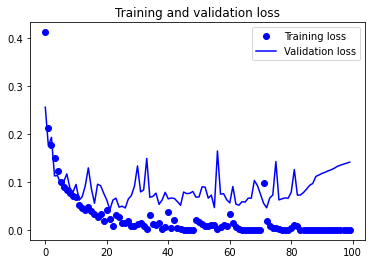

In [ ]:
loss = train.history['loss']
val_loss = train.history['val_loss']
epochs = range(100)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

In [ ]:
predIdxs = model.predict(testX, batch_size=32)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=CATEGORIES))

              precision    recall  f1-score   support

      damage       1.00      0.99      0.99      8000
   no_damage       0.92      0.97      0.95      1000

    accuracy                           0.99      9000
   macro avg       0.96      0.98      0.97      9000
weighted avg       0.99      0.99      0.99      9000



In [ ]:
from keras.models import load_model
predIdxs = load_model('best_VGG16.hdf5').predict(testX, batch_size=32)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=CATEGORIES))

              precision    recall  f1-score   support

      damage       1.00      0.99      0.99      8000
   no_damage       0.92      0.97      0.95      1000

    accuracy                           0.99      9000
   macro avg       0.96      0.98      0.97      9000
weighted avg       0.99      0.99      0.99      9000



In [ ]:
%cp '/gdrive/My Drive/best_VGG16.hdf5' .
CATEGORIES = ["damage", "no_damage"]
lb = LabelBinarizer()

testX = []
testY = []
for category in CATEGORIES:
    path = os.path.join('test/', category)
    for img in os.listdir(path):
    	img_path = os.path.join(path, img)
    	image = load_img(img_path, target_size=(128, 128, 3))
    	image = img_to_array(image)
    	image = preprocess_input(image)

    	testX.append(image)
    	testY.append(category)
     
testX = np.array(testX, dtype="float32")
testY = lb.fit_transform(testY)
testY = to_categorical(testY)
testY = np.array(testY)

from keras.models import load_model
predIdxs = load_model('best_VGG16.hdf5').predict(testX, batch_size=32)
predIdxs = np.argmax(predIdxs, axis=1)
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=CATEGORIES))

              precision    recall  f1-score   support

      damage       0.99      0.99      0.99      1000
   no_damage       0.99      0.99      0.99      1000

    accuracy                           0.99      2000
   macro avg       0.99      0.99      0.99      2000
weighted avg       0.99      0.99      0.99      2000

